In [1]:
import string
import re
from os import listdir
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Input
from keras.layers import Embedding
from keras.layers.merge import concatenate
from keras.models import Model
from IPython.display import Image

C:\Users\mgangwar\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [3]:
def clean_doc(doc, vocab):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # filter out tokens not in vocab
    tokens = [w for w in tokens if w in vocab]
    tokens = ' '.join(tokens)
    return tokens

In [4]:
def process_docs(directory, vocab, is_train):
    documents = list()
    # walk through all files in the folder
    for filename in listdir(directory):
        # skip any reviews in the test set
        if is_train and filename.startswith('cv9'):
            continue
        if not is_train and not filename.startswith('cv9'):
            continue
        # create the full path of the file to open
        path = directory + '/' + filename
        # load the doc
        doc = load_doc(path)
        # clean doc
        tokens = clean_doc(doc, vocab)
        # add to list
        documents.append(tokens)
    return documents

In [5]:
def load_clean_dataset(vocab,is_train):
    neg = process_docs('txt_sentoken/neg',vocab,is_train)
    pos = process_docs('txt_sentoken/pos',vocab,is_train)
    docs = neg + pos

    labels = [0 for _ in range (len(neg))] + [1 for _ in range(len(pos))]
    return docs,labels

#### Training CNN with Embedding layer

Convolutional neural networks (CNN) are effective at document classification,
namely because they are able to pick out salient features (e.g. tokens or sequences of tokens) in
a way that is invariant to their position within the input sequences.

Networks with convolutional and pooling layers are useful for classification tasks in
which we expect to find strong local clues regarding class membership, but these
clues can appear in different places in the input. [...] We would like to learn that
certain sequences of words are good indicators of the topic, and do not necessarily
care where they appear in the document. Convolutional and pooling layers allow
the model to learn to find such local indicators, regardless of their position.

The CNN is in essence a feature-extracting architecture. It does not constitute a
standalone, useful network on its own, but rather is meant to be integrated into a
larger network, and to be trained to work in tandem with it in order to produce an
end result. The CNNs layer's responsibility is to extract meaningful sub-structures
that are useful for the overall prediction task at hand.

A word embedding is a way of representing text where each word in
the vocabulary is represented by a real valued vector in a high-dimensional space. The vectors
are learned in such a way that words that have similar meanings will have similar representation
in the vector space (close in the vector space). This is a more expressive representation for text
than more classical methods like bag-of-words, where relationships between words or tokens are
ignored, or forced in bigram and trigram approaches.

The Keras Embedding
layer requires integer inputs where each integer maps to a single token that has a specific
real-valued vector representation within the embedding. These vectors are random at the
beginning of training, but during training become meaningful to the network.

In [6]:
#fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [7]:
def encode_docs(tokenizer, max_length, docs):
    # integer encode
    encoded = tokenizer.texts_to_sequences(docs)
    # pad sequences
    padded = pad_sequences(encoded, maxlen=max_length, padding='post')
    return padded

In [8]:
def define_model(vocab_size,max_length):
    model = Sequential()
    model.add(Embedding(vocab_size,100,input_length=max_length))
    model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(10,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    plot_model(model, to_file='model1.png', show_shapes=True)
    return model

In [9]:
# load the vocabulary
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())
len(vocab)

23275

In [10]:
train_docs, ytrain = load_clean_dataset(vocab, True)
test_docs, ytest = load_clean_dataset(vocab,False)
# create the tokenizer
tokenizer = create_tokenizer(train_docs)

In [11]:
print(len(train_docs))
print(len(test_docs))

1800
200


In [12]:
#The Embedding layer requires the specification of the vocabulary
#size, the size of the real-valued vector space, and the maximum length of input documents. The
#vocabulary size is the total number of words in our vocabulary, plus one for unknown words.
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary size: %d' % vocab_size)

Vocabulary size: 23276


In [13]:
#We also need to ensure that all documents have the same length. This is a
#requirement of Keras for eficient computation. We could truncate reviews to the smallest size
#or zero-pad (pad with the value 0) reviews to the maximum length, or some hybrid. In this case,
#we will pad all reviews to the length of the longest review in the training dataset. 

max_length = max([len(s.split()) for s in train_docs])
print('Maximum length: %d' % max_length)

Maximum length: 1277


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1277, 100)         2327600   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1270, 32)          25632     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 635, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 20320)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                203210    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 2,556,453
Trainable params: 2,556,453
Non-trainable params: 0
_________________________________________________________________


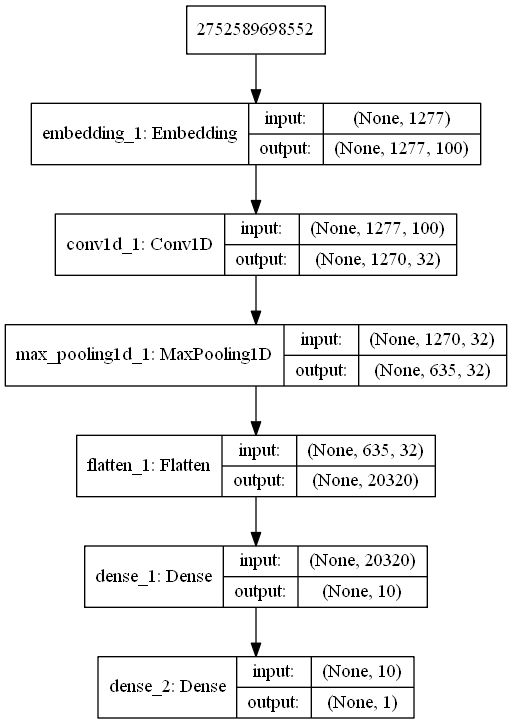

In [14]:
Xtrain = encode_docs(tokenizer, max_length, train_docs)
model = define_model(vocab_size,max_length)
Image(filename='model1.png')

In [15]:
model.fit(Xtrain,ytrain,epochs=10,verbose=2)

Epoch 1/10
 - 12s - loss: 0.6922 - acc: 0.5083
Epoch 2/10
 - 12s - loss: 0.5973 - acc: 0.6644
Epoch 3/10
 - 12s - loss: 0.1736 - acc: 0.9278
Epoch 4/10
 - 11s - loss: 0.0132 - acc: 1.0000
Epoch 5/10
 - 12s - loss: 0.0024 - acc: 1.0000
Epoch 6/10
 - 13s - loss: 0.0013 - acc: 1.0000
Epoch 7/10
 - 12s - loss: 9.1434e-04 - acc: 1.0000
Epoch 8/10
 - 12s - loss: 7.0725e-04 - acc: 1.0000
Epoch 9/10
 - 12s - loss: 5.6960e-04 - acc: 1.0000
Epoch 10/10
 - 12s - loss: 4.7525e-04 - acc: 1.0000


In [16]:
Xtest = encode_docs(tokenizer, max_length, test_docs)

_, acc = model.evaluate(Xtrain, ytrain, verbose=0)
print('Train Accuracy: %f' % (acc*100))
# evaluate model on test dataset
_, acc = model.evaluate(Xtest, ytest, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Train Accuracy: 100.000000
Test Accuracy: 85.000000


In [17]:
def predict_sentiment(review, vocab, tokenizer, max_length, model):
    line = clean_doc(review, vocab)
    # encode and pad review
    padded = encode_docs(tokenizer, max_length, [line])
    yhat = model.predict(padded, verbose=0)
    percent_pos = yhat[0,0]
    if round(percent_pos) == 0:
        return (1-percent_pos), 'NEGATIVE'
    return percent_pos, 'POSITIVE'

In [18]:
text = 'Everyone will enjoy this film. I love it, recommended!'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, max_length, model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))
# test negative text
text = 'This is a bad movie. Do not watch it. It sucks.'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, max_length, model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))

Review: [Everyone will enjoy this film. I love it, recommended!]
Sentiment: NEGATIVE (52.594%)
Review: [This is a bad movie. Do not watch it. It sucks.]
Sentiment: NEGATIVE (54.184%)
